# $k$-Nearest-Neighbours

$k$-Nearest-Nieghbours (shortened to kNN) is a popular distance based Machine Learning algorithm.

## Algorithm

The kNN algorithm is very simple. It is non-parametric, and the only hyperparameter needed is $k$, the number of nearest neighbours to $\underline{x}$ to use for classification.

The algorithm works like this:
1) Given an $X_{\mathrm{train}}\in \mathbb{R}^{m\times d}$ and a categorical variable $y_{\mathrm{train}}\in \{1,\cdots, C\}$ where $C$ is the number of unique classes

2) Take a test point, $\underline{x}$ and find it's distance to all the points in $X_{\mathrm{train}}$

3) Sort the distances in ascending order, making sure that the original index is saved

4) Take the first $k$ closest points, and determine their corresponding classes $y$

5) Classify $\underline{x}$ as the majority $y$ value from the $k$ nearest points

## Pros and Cons

- When $k$ is even, you can have undefined values for the majority vote. In such cases, different methods can be applied, for instance just randomly choosing one of the classes

- The simple kNN method using exhaustive search is computationally intensive (you can try this using the kNN function that I've coded!). Alternative algorithms such as kdtree accelerate the process, but become slow again once the dimensionality of the problem $d$ becomes really big. New libraries such as faiss by Facebook enable much faster kNN computation

- In general, the method becomes really inefficient as the dimensionality of the problem increases

## Implementation

In [1]:
def euclidean_dist(arr1, arr2):
    """ Function to calculate the distance between 2 points in Euclidean space """
    dist = 0
    for x1, x2 in zip(arr1, arr2):
        dist += (x1-x2)**2
    return dist**0.5



class kNN:
    """
    Implementation of the kNN algorithm, designed with the sklearn API in mind (i.e. use of methods .fit and .predict)
    
    Attributes:
    -----------
    
    k : int
        number of nearest neighbours
        
    metric : function
        metric to use to determine the nearest neighbour
        
    algorithm : str
        type of algorithm to use to fit the model, currently only supports brute
    
    """
    
    def __init__(self, k, metric, algorithm = 'brute'):
        self.k = k
        self.metric = metric
        self.algorithm = algorithm
    
    
    def fit(self, X, y):
        if self.algorithm == 'brute':
            self.X = X
            self.y = y
    
    def predict(self, X, ignore_duplicates = True):
        """
        X : np.array
            Test array with m samples and n dimensions
            
        ignore_duplicates : bool
            if set to true, then only the k nearest points as they appear in memory will be considered
            setting to False is for cases where you want to consider points that are of the same distance
            away to be identical. The tutorial requires this to be set to False.
        """
        
        y_pred = []        
        
        for x_test in X:
            if self.algorithm == 'brute':
                dist = [self.metric(x_test, x_train) for x_train in self.X]
            dist, y = zip(*sorted(zip(dist, self.y)))
            
            if ignore_duplicates:
                # only takes the closest k points as they appear in memory
                y = y[:self.k]
            else:
                # treats points that are equally far from our test point as the same
                i = 0
                dist_unique = set()
                while i < len(dist) and len(dist_unique) <= self.k:
                    if dist[i] not in dist_unique:
                        dist_unique.add(dist[i])
                    i+=1
                y = y[:i]

            
            if self.k % 2 == 0 and sum(y) == len(y) - sum(y):
                # case for k = even. This is only valid for a binary classifier
                # TODO can you generalise this for any k?
                
                # if unsure which to use, choose randomly between 1 and 0
                y_pred.append(np.random.randint(0, 2))
                
            else:
                y_pred.append(max(y,key=y.count))
                
        return np.asarray(y_pred)

## Example: toy case

- The fit function normally does some training, but in the case of a simple implementation kNN, this has the purpose of simply storing the data. For more info click [here](https://stats.stackexchange.com/questions/349842/why-do-we-need-to-fit-a-k-nearest-neighbors-classifier)
- make sure to use the log(nsamples) to estimate which k to use
- add stuff about evaluating the algorithm, error, cross validation, plot of the voronoi cells ?

In [2]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

# data generation modules
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split


# plotting
import matplotlib.pyplot as plt
from PythonFiles.plotting import plot_classes #plot_contour

# mathematical
import numpy as np
import math

Text(0, 0.5, '$x_2$')

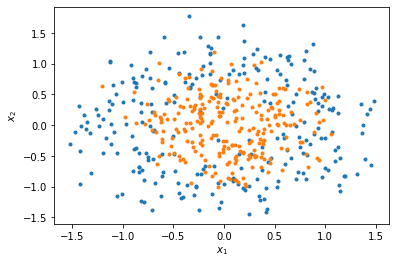

In [4]:
# load the dataset
n_samples = 500
X,y = make_circles(n_samples, noise = 0.3, factor =0.5)

# visualize plot
fig, ax = plot_classes(X, y)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

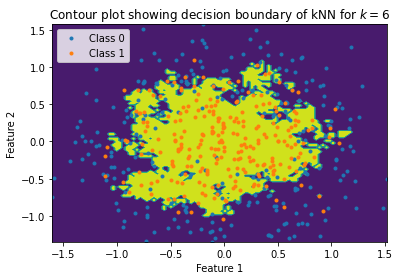

In [62]:
# create our model

k = round(math.log(n_samples))

model = kNN(k, euclidean_dist)

model.fit(X, y)

# create a contour plot
plot_contour(model, xlim = (min(X[:,0]), max(X[:,0])), ylim = (min(X[:,1]), max(X[:,1])), plot = (fig, ax), n=100)

ax.set_title(f'Contour plot showing decision boundary of kNN for $k=${k}')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend(['Class 0', 'Class 1'])

fig

# Experiments

Here we take a look at the impact of $k$ on error, and how the optimal value of $k$ changes with the size of the dataset $m$

## TODO
- add experiment for measuring bias vs. variance
- can you compare model performance to bayes estimator?

In [8]:
import faiss
from time import time
#from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier



class kNN_faiss:
    """
    Implements kNN using Facebook's faiss library for fast computation
    
    Attributes:
    -----------
    
    k : int
        the number of nearest neighbours to use
    
    """
    
    def __init__(self, k=3):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        """
        Fits the model. Here faiss prepares the index (data structure) that is used for kNN computation
        """
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [94]:
# algorithm for determining optimal k

def generalisation_error(
        model,
        data_generator,
        k_range = [1,50],
        runs = 100,
        test_size = 0.2,
        seed = None
):
    """
    Determines the generalisation error as a function of k

    model : class
        Class of the model to use. Must be built using sklearn API
    
    data_generator : tuple
        tuple in the form (generator_function, parameters)
        
    k_range : iterable
        defines the range of k's to use for the problem. Defaults to [1,50)
        
    runs : int
        indicates how many times to repeat the experiment
        
    test_size : float
        indicates percentage of train set to use for testing

    """
    data_generator, parameters = data_generator

    global_errors = []
    tot_time = 0
    for i, k_ in enumerate(k_range):
        start = time()
        print(f'We are at k={k_}')
        tot_err = 0
        for run in range(runs):
            X, y = data_generator(**parameters)
            
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
            
            kNN_model = model(k_)
            kNN_model.fit(X_train, y_train)

            y_hat = kNN_model.predict(
                X_test.astype(np.float32)
                #np.ascontiguousarray(X_test),
            )

            correctness_index = [y_hat_ == y_test_ for y_hat_, y_test_ in zip(y_hat, y_test)]

            tot_err += (len(correctness_index) - sum(correctness_index)) / len(correctness_index)

        global_errors.append(tot_err / runs)
        time_taken = time() - start
        tot_time += time_taken
        print(f'Time taken for k={k_} is {time_taken}. Estimated time remaining is {(tot_time / (i+1)) * (len(k_range) - i - 1)}')

        # average the generalisation error

    return global_errors

In [96]:
num_k = 100
n_samples = 500
test_size = 0.2
k = np.linspace(1, n_samples*(1-test_size) - 1, num_k, dtype = int)
errors = generalisation_error(
    KNeighborsClassifier,
    data_generator = (make_circles, {"n_samples":n_samples, "noise":0.3, "factor":0.5}),
    k_range = k,
    test_size = test_size
)

We are at k=1
Time taken for k=1 is 0.5552058219909668. Estimated time remaining is 54.96537637710571
We are at k=5
Time taken for k=5 is 0.6944808959960938. Estimated time remaining is 61.23464918136597
We are at k=9
Time taken for k=9 is 0.625647783279419. Estimated time remaining is 60.6358155409495
We are at k=13
Time taken for k=13 is 0.5516948699951172. Estimated time remaining is 58.24870491027832
We are at k=17
Time taken for k=17 is 0.645298957824707. Estimated time remaining is 58.37423825263976
We are at k=21
Time taken for k=21 is 0.6553771495819092. Estimated time remaining is 58.400719165802
We are at k=25
Time taken for k=25 is 0.6053938865661621. Estimated time remaining is 57.56832013811383
We are at k=29
Time taken for k=29 is 0.60294508934021. Estimated time remaining is 56.76451122760773
We are at k=33
Time taken for k=33 is 0.6744177341461182. Estimated time remaining is 56.72800657484267
We are at k=37
Time taken for k=37 is 1.1034550666809082. Estimated time rema

Time taken for k=314 is 0.8173627853393555. Estimated time remaining is 19.633197621454165
We are at k=318
Time taken for k=318 is 1.0657882690429688. Estimated time remaining is 18.73100197315216
We are at k=322
Time taken for k=322 is 1.0567927360534668. Estimated time remaining is 17.822656937587407
We are at k=326
Time taken for k=326 is 1.3084590435028076. Estimated time remaining is 16.965935049987422
We are at k=330
Time taken for k=330 is 1.1306631565093994. Estimated time remaining is 16.061911904668232
We are at k=334
Time taken for k=334 is 1.195378065109253. Estimated time remaining is 15.164819217863537
We are at k=338
Time taken for k=338 is 1.070302963256836. Estimated time remaining is 14.238635974771835
We are at k=342
Time taken for k=342 is 1.1144540309906006. Estimated time remaining is 13.316288493400396
We are at k=346
Time taken for k=346 is 1.1408121585845947. Estimated time remaining is 12.393463340298883
We are at k=350
Time taken for k=350 is 1.17787599563598

Text(0, 0.5, 'Error')

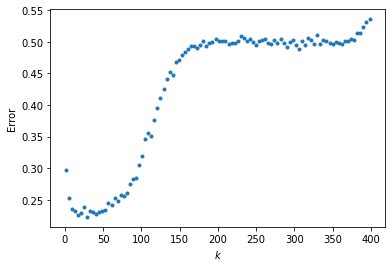

In [97]:
plt.plot(k, errors, '.')
plt.xlabel('$k$')
plt.ylabel('Error')

The reason why the error shoots up at the end is because of class imbalance. We can see this by sampling.

In [ ]:
more_freq_class_percent = 0
n_repeats = 10000
for i in range(n_repeats):
    X, y = make_circles(n_samples = 500, factor = 0.5, noise = 0.3)         
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    more_freq_class_percent += max(sum(y_test == 1), sum(y_test == 0))/len(y_test)
print(f"Average frequency of more frequent class in test set {more_freq_class_percent/n_repeats}" )

To verify this, try repeating the generalisation_error plot but set the train_test_split with stratify=y

## The decision boundary: how k affects smoothness

In [ ]:
X, y = make_circles(n_samples = 500, factor = 0.5, noise = 0.3)
fig, ax = plot_classes(X, y)

for k in [1, 5, 25, 250]:
    fig, ax = plot_classes(X, y)

    model = KNeighborsClassifier(k)

    model.fit(X, y)

# create a contour plot
    plot_contour(model, xlim = (min(X[:,0]), max(X[:,0])), ylim = (min(X[:,1]), max(X[:,1])), plot = (fig, ax), n=100)

    ax.set_title(f'Contour plot showing decision boundary of kNN for $k=${k}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(['Class 0', 'Class 1'])

In [52]:
def generate_k_range(n_points, n_samples, n_fine = 15):

    k = list(range(1, n_fine)) + list(np.linspace(n_fine, n_samples - n_fine , n_points, dtype = int)) + sorted(list(range(n_samples - 1, n_samples - n_fine, -1)))
    return k

def optimal_k(
        model,
        data_generator,
        m_range,
        runs = 100,
        test_size = 0.2,
        seed = None
):
    """
    Determines the optimal k m

    model : class
        Class of the model to use. Must be built using sklearn API
    
    data_generator : tuple
        tuple in the form (generator_function, parameters)
        
    m_range : iterable
        defines the range of the number of samples to use for the problem. Defaults to [1,50)
        
    runs : int
        indicates how many times to repeat the experiment
        
    test_size : float
        indicates percentage of train set to use for testing

    """
    data_generator, parameters = data_generator


    global_optimal_k = []
    tot_time = 0
    for m_ in m:
        print(f'We are now at m = {m_}')
        optimal_k = []
        start = time()
        for run in range(runs):
            errors = []            
            #k = generate_k_range(n_points = 100, n_samples = int((1-test_size) * m_), n_fine = 30)
            k = np.linspace(1, int((1-test_size) * m_), 100, dtype = int)
            k = sorted(set(k))
            for k_ in k:
                parameters['n_samples'] = m_
                X, y = data_generator(**parameters)
                
            
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
                """fig, ax = plot_classes(X_train, y_train)"""
                # train KNN on this data
                kNN_model = model(k_)
                kNN_model.fit(X_train, y_train)


                # calculate y_hat
                y_hat = kNN_model.predict(
                    X_test,
                )
                
                # consider doing this with leave one out validation to determine the error! Can you see
                # if that makes any difference to the plot?
                correctness_index = [y_hat_ == y_test_ for y_hat_, y_test_ in zip(y_hat, y_test)]
                """fig, ax = plot_classes(X_test[correctness_index], y_test[correctness_index], plot = (fig, ax), shape = '*')
                fig, ax = plot_classes(
                    X_test[[not i for i in correctness_index]],
                    y_test[[not i for i in correctness_index]], plot = (fig, ax), shape = 'o')
                if k_ == k[2]:
                    raise Exception()"""
                errors.append((len(correctness_index) - sum(correctness_index)) / len(correctness_index))
            optimal_k.append(min(zip(errors, k))[1])
        
        time_taken = time() - start
        tot_time += time_taken
        # TODO correct time estimation
        #print(f'Time taken for m={m_} is {time_taken}. Estimated time remaining is {(tot_time / len(k)) * (49 - k_)}')
        print(sum(optimal_k) / len(optimal_k))
        global_optimal_k.append(sum(optimal_k) / len(optimal_k))
    print(f'Total time taken is t={tot_time}')
    return global_optimal_k, m


In [54]:
max_samples = 4000
test_size = 0.2
min_samples = 100
m = np.linspace(min_samples, max_samples, 50, dtype = int)
m = sorted(set(m))
errors = optimal_k(
    KNeighborsClassifier,
    data_generator = (make_circles, {"n_samples":"dynamic", "noise":0.3, "factor":0.5}),
    m_range = m,
    test_size = test_size
)

We are now at m = 100
10.02
We are now at m = 179
15.07
We are now at m = 259
22.0
We are now at m = 338
26.7
We are now at m = 418
36.54
We are now at m = 497
36.68
We are now at m = 577
44.54
We are now at m = 657
50.73
We are now at m = 736
50.59
We are now at m = 816
56.93
We are now at m = 895
63.57
We are now at m = 975
67.45
We are now at m = 1055
80.65
We are now at m = 1134
76.24
We are now at m = 1214
91.23
We are now at m = 1293
88.6
We are now at m = 1373
101.68
We are now at m = 1453
102.89
We are now at m = 1532
102.62
We are now at m = 1612
110.07
We are now at m = 1691
113.53
We are now at m = 1771
115.87
We are now at m = 1851
113.83
We are now at m = 1930
138.41
We are now at m = 2010
116.09
We are now at m = 2089
134.21
We are now at m = 2169
151.8
We are now at m = 2248
147.35
We are now at m = 2328
166.2
We are now at m = 2408
157.03
We are now at m = 2487
155.77
We are now at m = 2567
168.63
We are now at m = 2646
155.62
We are now at m = 2726
176.56
We are now at

Text(0, 0.5, 'Optimal value of $k$')

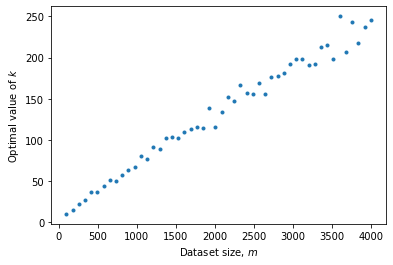

In [56]:
plt.plot(m, errors[0], '.')
plt.xlabel('Dataset size, $m$')
plt.ylabel('Optimal value of $k$')

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

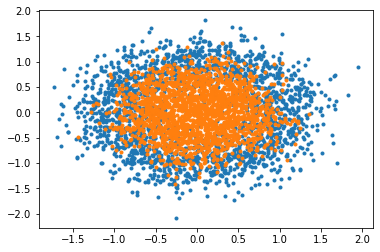

In [58]:
plot_classes(*make_circles(4000, noise = 0.3, factor = 0.5))

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

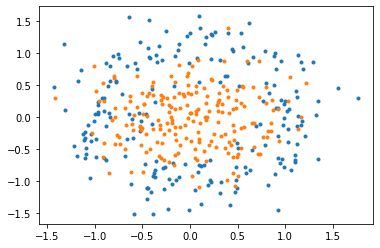

In [59]:
plot_classes(*make_circles(400, noise = 0.3, factor = 0.5))

In [26]:
errors = {k : err/100 for k, err in errors.items()}

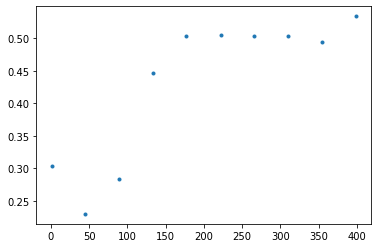

In [29]:
plt.plot(k_range, errors.values(), '.')

Text(0, 0.5, 'Optimal value of $k$')

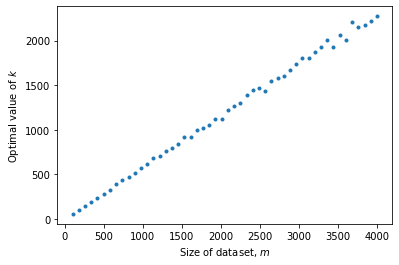

In [145]:
plt.plot(m, errors[0], '.')
plt.xlabel('Size of dataset, $m$')
plt.ylabel('Optimal value of $k$')


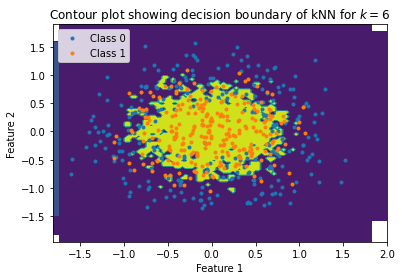

In [150]:
n_samples = 5000
X,y = make_circles(n_samples, noise = 0.3, factor =0.5, random_state= 0)

#k = round(math.log(n_samples))
k = 6 #int(n_samples/2)

model = KNeighborsClassifier(k)

model.fit(X, y)

# create a contour plot
plot_contour(model, xlim = (min(X[:,0]), max(X[:,0])), ylim = (min(X[:,1]), max(X[:,1])), plot = (fig, ax), n=100)

ax.set_title(f'Contour plot showing decision boundary of kNN for $k=${k}')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend(['Class 0', 'Class 1'])

fig

# Useful Links

https://stats.stackexchange.com/questions/485884/bias-and-variance-in-knn-and-decision-trees
https://stats.stackexchange.com/questions/107870/does-k-nn-with-k-1-always-implies-overfitting
https://stackoverflow.com/questions/5751114/nearest-neighbors-in-high-dimensional-data
https://stackoverflow.com/questions/33508247/how-to-handle-duplicate-data-points-in-k-nearest-neighbor-algorithm